# Regression tree models

As well as our final CatBoost model (__london_cycle_count_analysis.ipynb__), we attempted some others.

These did not perform as well as the CatBoost model but are included below for completeness. 

### Set up data

In [1]:
# Import packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import catboost as cb
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [2]:
# Load the processed data for modelling 
london_model = pd.read_csv('london_count_sites/london_model.csv')

In [3]:
# Set categorical categories as category 
cat_cols = ['month', 'day_of_week', 'period', 'area', 'borough', 'weather']
for col in cat_cols:
    london_model[col] = london_model[col].astype('category')
    london_model[col] = london_model[col].cat.codes

# Record categorical columns 
cat_index = []
for col in cat_cols:
    cat_index.append(london_model.columns.get_loc(col))

In [4]:
# Set up training and test datasets 
X = london_model.drop(['total_cycles'], axis=1)
y = london_model.total_cycles

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)
X_train, X_eval, y_train, y_eval = train_test_split(X_train, y_train, test_size=0.25, random_state=13)

train_dataset = cb.Pool(X_train, y_train, cat_features=cat_index) 
eval_dataset = cb.Pool(X_eval, y_eval, cat_features=cat_index)
test_dataset = cb.Pool(X_test, y_test, cat_features=cat_index)

# Regression Tree

Regression trees work on continuous data and try to predict a numeric value based on a set of independent features.

In [5]:
# Create the decision tree regressor class and for the object to the data set
regressor = DecisionTreeRegressor(random_state = 0)
regressor.fit(X_train, y_train)

DecisionTreeRegressor(random_state=0)

In [6]:
# Evaluate the model prediction by predicting the response for the test data
y_pred = regressor.predict(X_test)

# Specify the MAE and RMSE
mae = round(metrics.mean_absolute_error(y_test, y_pred), 2)
rmse = round(np.sqrt(metrics.mean_squared_error(y_test, y_pred)),2)

print('Mean Absolute Error: ', mae)
print('Root Mean Squared Error:', rmse)
print(round(rmse-mae,2))

Mean Absolute Error:  5.26
Root Mean Squared Error: 12.11
6.85


The difference between RMSE and MAE determines how well the regression tree has performed. The closer to 0 the better the fit on the dataset. With a value of 6.85, the value is fairly low. 

To determine the feature importance, an evaluation is performed on the independent variables

Feature: 0, Score: 0.04987
Feature: 1, Score: 0.03993
Feature: 2, Score: 0.02766
Feature: 3, Score: 0.14123
Feature: 4, Score: 0.08400
Feature: 5, Score: 0.00398
Feature: 6, Score: 0.02116
Feature: 7, Score: 0.01005
Feature: 8, Score: 0.08697
Feature: 9, Score: 0.00003
Feature: 10, Score: 0.00649
Feature: 11, Score: 0.12523
Feature: 12, Score: 0.01421
Feature: 13, Score: 0.19517
Feature: 14, Score: 0.07968
Feature: 15, Score: 0.04266
Feature: 16, Score: 0.07169


<AxesSubplot:xlabel='Importance', ylabel='Variable'>

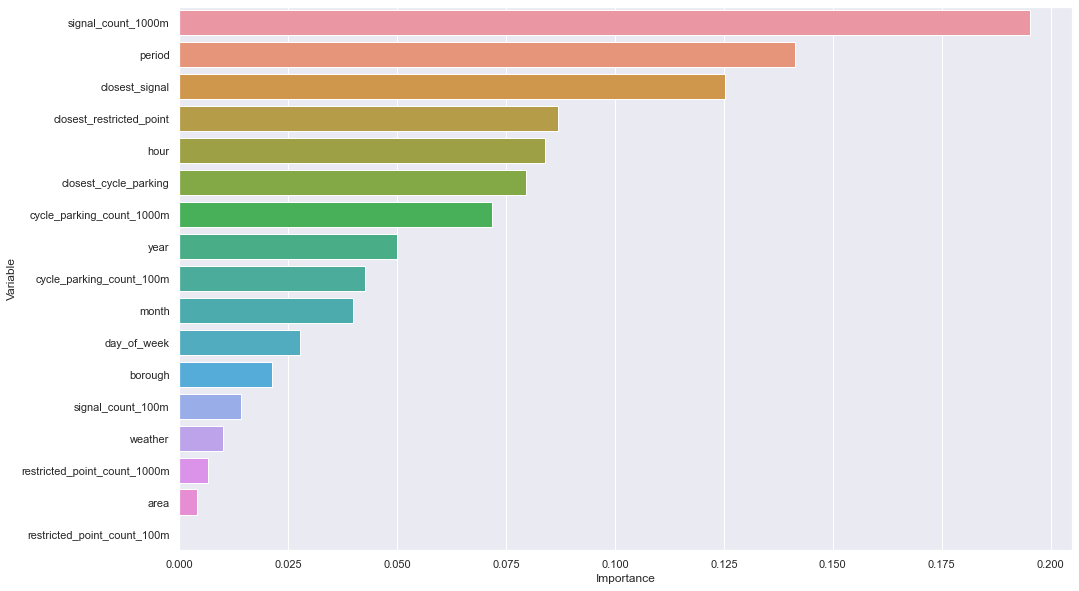

In [7]:
# Get importance
importance = regressor.feature_importances_

# Summarise the feature importance
for i, v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
    
# Bring the features into a df and visualise the feature importances
reg_tree_importance = pd.DataFrame({'Variable': X.columns,
                                    'Importance': importance})\
                                    .sort_values('Importance', ascending = False)

sns.set(rc={'figure.figsize':(16,10)})
sns.barplot(data = reg_tree_importance, x = 'Importance', y = 'Variable')

In [8]:
# Show the difference between labeled and predicted y values
import warnings
warnings.filterwarnings("ignore") 

sns.distplot(y_test-y_pred)

<AxesSubplot:xlabel='total_cycles', ylabel='Density'>

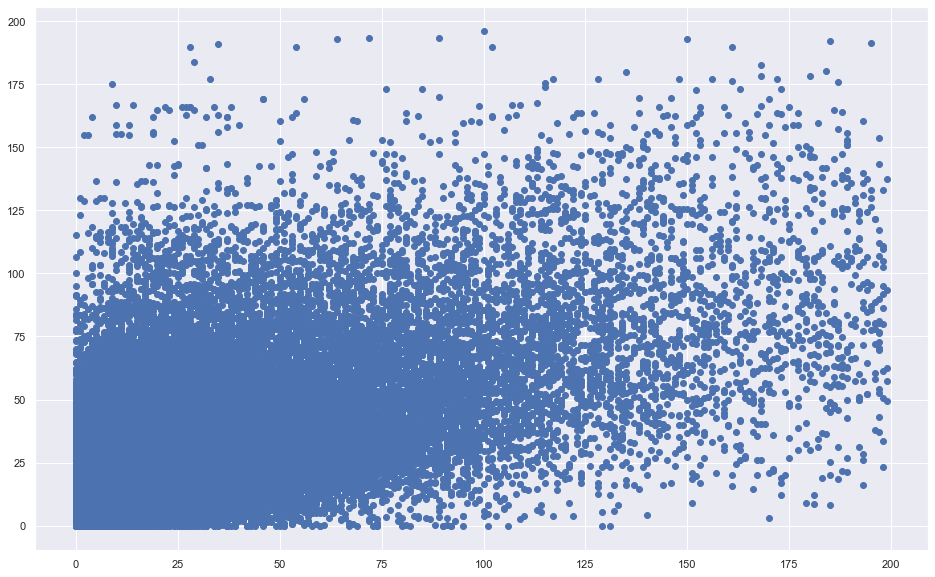

In [9]:
# Checking the predicted values using a scatter plot
plt.scatter(y_test,y_pred)

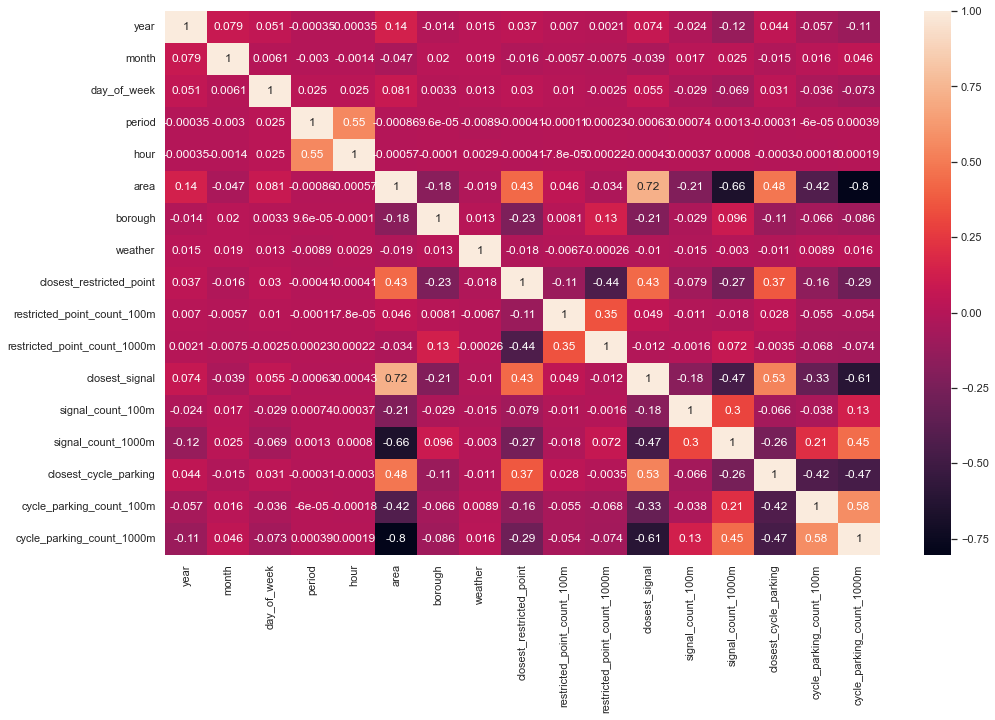

In [10]:
# Check for multicollinearity in the model
correlation_matrix = X.corr()
sns.heatmap(correlation_matrix, annot = True)
plt.show()

At first glance the notable correlation is betwen area and cycle parking counts in km range. Closest signal and area also seem to be quite highly correlated. 

## Random forest

Next a random forest algorithm is used to compare the output of the decision tree. 
It generally performs better than a single regression tree. 

In [11]:
# Run the random forest with
forest = RandomForestRegressor(verbose = 1, n_estimators = 1000, max_features = 'sqrt', bootstrap = False,
                               n_jobs = -1, max_depth = 20, min_samples_leaf = 1, min_samples_split = 5)

forest.fit(X_train, y_train)
forest_predict = forest.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   36.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 12.9min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 16.5min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.9s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:   15.8s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:   34.9s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:  1.0min
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:  1.3min finished


In [12]:
# Print the model evaluation
mae_forest = round(metrics.mean_absolute_error(y_test, forest_predict), 2)
rmse_forest = round(np.sqrt(metrics.mean_squared_error(y_test, forest_predict)), 2)

print(round(mae_forest,2))
print(round(rmse_forest,2))
print(round(rmse_forest-mae_forest,2))

5.04
11.29
6.25


The difference between the RMSE and MAE is 6.25 using the random forest regression model. This performs slightly better than the single regression tree but not better than the CatBoost model. 

The feature importances are evaluated next. 

In [13]:
# Create a DF to store the importances of the variables
forest_df = pd.DataFrame({'Variable': X.columns,
                         'Importance': forest.feature_importances_})\
                         .sort_values('Importance', ascending = False)


# Visualize the importances with a bachart
sns.set(rc={'figure.figsize':(16,10)})

viz = sns.barplot(data = forest_df,
                  x = 'Importance',
                  y = 'Variable')

viz.set_xticklabels(viz.get_xticklabels(), rotation = 40, ha = 'right')
plt.show()